In [1]:
# Protein Structure-Function ML Project
# Analysis and Interpretation Notebook

import pandas as pd
import numpy as np
import pickle
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import joblib
import warnings
warnings.filterwarnings('ignore')

# Setup plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('notebook', font_scale=1.1)

print("=== PROTEIN STRUCTURE-FUNCTION ANALYSIS ===")

# Load ML dataset
with open("../data/processed/ml_ready_dataset.pkl", 'rb') as f:
    ml_dataset = pickle.load(f)

X = ml_dataset['features']
y = ml_dataset['labels']
protein_names = ml_dataset['protein_names']
feature_names = ml_dataset['feature_names']
ec_classes = ml_dataset['ec_classes']

# Load trained models
try:
    rf_model_data = joblib.load("../models/random_forest_model.pkl")
    svm_model_data = joblib.load("../models/svm_model.pkl")
    
    rf_model = rf_model_data['model']
    svm_model = svm_model_data['model']
    scaler = rf_model_data['scaler']
    label_encoder = rf_model_data['label_encoder']
    
    print("✓ Models loaded successfully")
except:
    print("❌ Could not load models. Please run notebook 03 first.")
    raise

# Load results summary
try:
    with open("../reports/results_summary.json", 'r') as f:
        results = json.load(f)
    print("✓ Results summary loaded")
except:
    print("⚠ Results summary not found - will generate from scratch")

# Load integrated features for detailed analysis
integrated_df = pd.read_csv("../data/processed/integrated_features.csv")

print(f"\n=== DATASET OVERVIEW ===")
print(f"Total proteins: {len(protein_names)}")
print(f"Features: {len(feature_names)}")
print(f"EC classes: {ec_classes}")
print(f"Class distribution: {dict(pd.Series(y).value_counts().sort_index())}")

=== PROTEIN STRUCTURE-FUNCTION ANALYSIS ===
✓ Models loaded successfully
✓ Results summary loaded

=== DATASET OVERVIEW ===
Total proteins: 33
Features: 43
EC classes: ['1', '2', '3', '4']
Class distribution: {'1': np.int64(6), '2': np.int64(8), '3': np.int64(11), '4': np.int64(8)}


=== DETAILED PERFORMANCE ANALYSIS ===
Random Forest Accuracy: 0.9394 (93.9%)
SVM Accuracy: 0.9394 (93.9%)

=== RANDOM FOREST CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

        EC 1       1.00      0.83      0.91         6
        EC 2       0.89      1.00      0.94         8
        EC 3       0.92      1.00      0.96        11
        EC 4       1.00      0.88      0.93         8

    accuracy                           0.94        33
   macro avg       0.95      0.93      0.94        33
weighted avg       0.95      0.94      0.94        33


=== SVM CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

        EC 1       1.00      0.83      0.91         6
        EC 2       0.89      1.00      0.94         8
        EC 3       0.92      1.00      0.96        11
        EC 4       1.00      0.88      0.93         8

    accuracy                           0.94        33
   macro avg       0.95      0.93      0.94        33

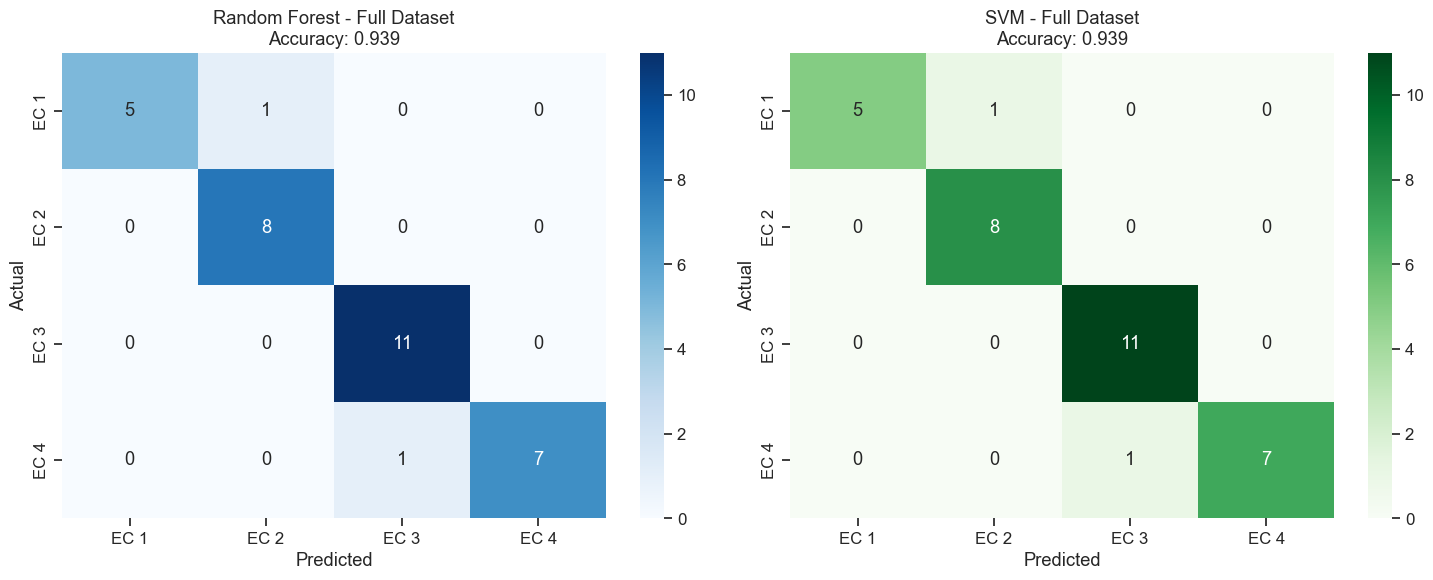


=== PER-CLASS PERFORMANCE ANALYSIS ===
EC_Class  RF_Precision  RF_Recall  RF_F1  SVM_Precision  SVM_Recall  SVM_F1  Support
    EC 1         1.000      0.833  0.909          1.000       0.833   0.909        6
    EC 2         0.889      1.000  0.941          0.889       1.000   0.941        8
    EC 3         0.917      1.000  0.957          0.917       1.000   0.957       11
    EC 4         1.000      0.875  0.933          1.000       0.875   0.933        8

✓ Per-class performance saved to ../reports/per_class_performance.csv


In [2]:
# Detailed Performance Analysis
print("=== DETAILED PERFORMANCE ANALYSIS ===")

# Scale features for prediction
X_scaled = scaler.transform(X)
y_encoded = label_encoder.transform(y)

# Get predictions from both models
rf_predictions = rf_model.predict(X_scaled)
svm_predictions = svm_model.predict(X_scaled)

# Convert predictions back to original labels
rf_pred_labels = label_encoder.inverse_transform(rf_predictions)
svm_pred_labels = label_encoder.inverse_transform(svm_predictions)

# Performance metrics
rf_accuracy = (rf_pred_labels == y).mean()
svm_accuracy = (svm_pred_labels == y).mean()

print(f"Random Forest Accuracy: {rf_accuracy:.4f} ({rf_accuracy:.1%})")
print(f"SVM Accuracy: {svm_accuracy:.4f} ({svm_accuracy:.1%})")

# Detailed classification reports
print(f"\n=== RANDOM FOREST CLASSIFICATION REPORT ===")
print(classification_report(y, rf_pred_labels, target_names=[f"EC {ec}" for ec in sorted(ec_classes)]))

print(f"\n=== SVM CLASSIFICATION REPORT ===")
print(classification_report(y, svm_pred_labels, target_names=[f"EC {ec}" for ec in sorted(ec_classes)]))

# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Full dataset confusion matrices
cm_rf_full = confusion_matrix(y, rf_pred_labels, labels=sorted(ec_classes))
cm_svm_full = svm_predictions = svm_model.predict(X_scaled)
cm_svm_full = confusion_matrix(y, svm_pred_labels, labels=sorted(ec_classes))

# Plot confusion matrices
sns.heatmap(cm_rf_full, annot=True, fmt='d', cmap='Blues',
           xticklabels=[f'EC {ec}' for ec in sorted(ec_classes)],
           yticklabels=[f'EC {ec}' for ec in sorted(ec_classes)],
           ax=axes[0])
axes[0].set_title(f'Random Forest - Full Dataset\nAccuracy: {rf_accuracy:.3f}')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(cm_svm_full, annot=True, fmt='d', cmap='Greens',
           xticklabels=[f'EC {ec}' for ec in sorted(ec_classes)],
           yticklabels=[f'EC {ec}' for ec in sorted(ec_classes)],
           ax=axes[1])
axes[1].set_title(f'SVM - Full Dataset\nAccuracy: {svm_accuracy:.3f}')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.savefig("../reports/figures/full_dataset_confusion_matrices.png", dpi=300, bbox_inches='tight')
plt.show()

# Per-class performance analysis
print(f"\n=== PER-CLASS PERFORMANCE ANALYSIS ===")
from sklearn.metrics import precision_recall_fscore_support

# Random Forest per-class metrics
rf_precision, rf_recall, rf_f1, rf_support = precision_recall_fscore_support(
    y, rf_pred_labels, labels=sorted(ec_classes), average=None
)

# SVM per-class metrics  
svm_precision, svm_recall, svm_f1, svm_support = precision_recall_fscore_support(
    y, svm_pred_labels, labels=sorted(ec_classes), average=None
)

# Create performance comparison dataframe
performance_df = pd.DataFrame({
    'EC_Class': [f'EC {ec}' for ec in sorted(ec_classes)],
    'RF_Precision': rf_precision,
    'RF_Recall': rf_recall,
    'RF_F1': rf_f1,
    'SVM_Precision': svm_precision,
    'SVM_Recall': svm_recall,
    'SVM_F1': svm_f1,
    'Support': rf_support
})

print(performance_df.round(3).to_string(index=False))

# Save performance analysis
performance_df.to_csv("../reports/per_class_performance.csv", index=False)
print(f"\n✓ Per-class performance saved to ../reports/per_class_performance.csv")

=== FEATURE IMPORTANCE ANALYSIS ===


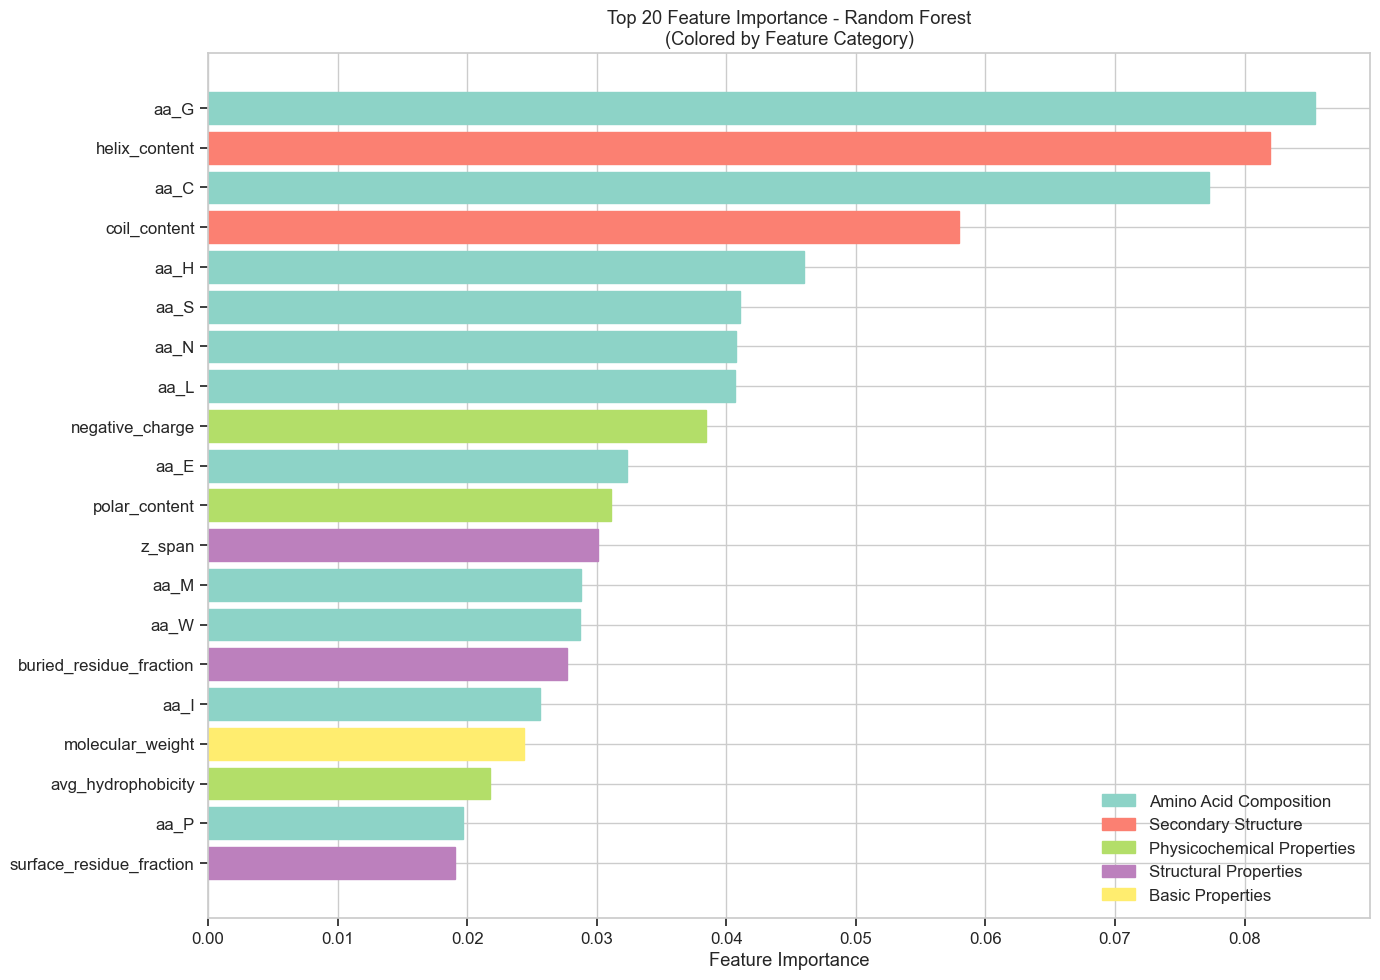


=== FEATURE IMPORTANCE BY CATEGORY ===
                            Total_Importance  Mean_Importance  Feature_Count
category                                                                    
Amino Acid Composition                0.5586           0.0279             20
Secondary Structure                   0.1534           0.0256              6
Structural Properties                 0.1399           0.0140             10
Physicochemical Properties            0.1104           0.0221              5
Basic Properties                      0.0378           0.0189              2

=== BIOLOGICAL INTERPRETATION OF TOP FEATURES ===
aa_G                 (0.0854): Glycine flexibility - crucial for enzyme active sites
helix_content        (0.0820): Alpha-helix structure - determines protein stability and function
aa_C                 (0.0773): Cysteine content - important for disulfide bonds and structure
coil_content         (0.0580): Random coil regions - often contain active sites
aa_H          

In [3]:
# Feature Importance and Biological Interpretation
print("=== FEATURE IMPORTANCE ANALYSIS ===")

# Get feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Categorize features for analysis
def categorize_feature(feature_name):
    if feature_name.startswith('aa_'):
        return 'Amino Acid Composition'
    elif feature_name in ['sequence_length', 'molecular_weight']:
        return 'Basic Properties'
    elif feature_name in ['avg_hydrophobicity', 'positive_charge', 'negative_charge', 'aromatic_content', 'polar_content']:
        return 'Physicochemical Properties'
    elif feature_name in ['helix_content', 'sheet_content', 'coil_content', 'estimated_helix_percent', 'estimated_sheet_percent', 'estimated_coil_percent']:
        return 'Secondary Structure'
    else:
        return 'Structural Properties'

feature_importance['category'] = feature_importance['feature'].apply(categorize_feature)

# Plot feature importance by category
plt.figure(figsize=(14, 10))

# Top 20 features colored by category
top20 = feature_importance.head(20)
colors = plt.cm.Set3(np.linspace(0, 1, len(top20['category'].unique())))
category_colors = dict(zip(top20['category'].unique(), colors))

bars = plt.barh(range(len(top20)), top20['importance'])
for i, (feature, category) in enumerate(zip(top20['feature'], top20['category'])):
    bars[i].set_color(category_colors[category])

plt.yticks(range(len(top20)), top20['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importance - Random Forest\n(Colored by Feature Category)')
plt.gca().invert_yaxis()

# Add legend
handles = [plt.Rectangle((0,0),1,1, color=color) for color in category_colors.values()]
plt.legend(handles, category_colors.keys(), loc='lower right')

plt.tight_layout()
plt.savefig("../reports/figures/detailed_feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

# Feature importance by category
category_importance = feature_importance.groupby('category')['importance'].agg(['sum', 'mean', 'count']).round(4)
category_importance.columns = ['Total_Importance', 'Mean_Importance', 'Feature_Count']
category_importance = category_importance.sort_values('Total_Importance', ascending=False)

print(f"\n=== FEATURE IMPORTANCE BY CATEGORY ===")
print(category_importance)

# Biological interpretation of top features
print(f"\n=== BIOLOGICAL INTERPRETATION OF TOP FEATURES ===")
top_features = feature_importance.head(10)

interpretations = {
    'aa_G': 'Glycine flexibility - crucial for enzyme active sites',
    'helix_content': 'Alpha-helix structure - determines protein stability and function',
    'aa_C': 'Cysteine content - important for disulfide bonds and structure',
    'aa_A': 'Alanine content - affects protein compactness',
    'estimated_helix_percent': 'Secondary structure prediction - functional determinant',
    'coil_content': 'Random coil regions - often contain active sites',
    'aa_P': 'Proline content - creates structural rigidity and turns',
    'avg_hydrophobicity': 'Overall hydrophobicity - affects protein folding',
    'sheet_content': 'Beta-sheet structure - determines protein architecture',
    'negative_charge': 'Negatively charged residues - important for catalysis'
}

for _, row in top_features.iterrows():
    feature = row['feature']
    importance = row['importance']
    interpretation = interpretations.get(feature, 'Structure-function relationship')
    print(f"{feature:20s} ({importance:.4f}): {interpretation}")

# Save feature analysis
feature_importance.to_csv("../reports/feature_importance_detailed.csv", index=False)
category_importance.to_csv("../reports/feature_importance_by_category.csv")
print(f"\n✓ Feature analysis saved")

=== DIMENSIONALITY REDUCTION ANALYSIS ===


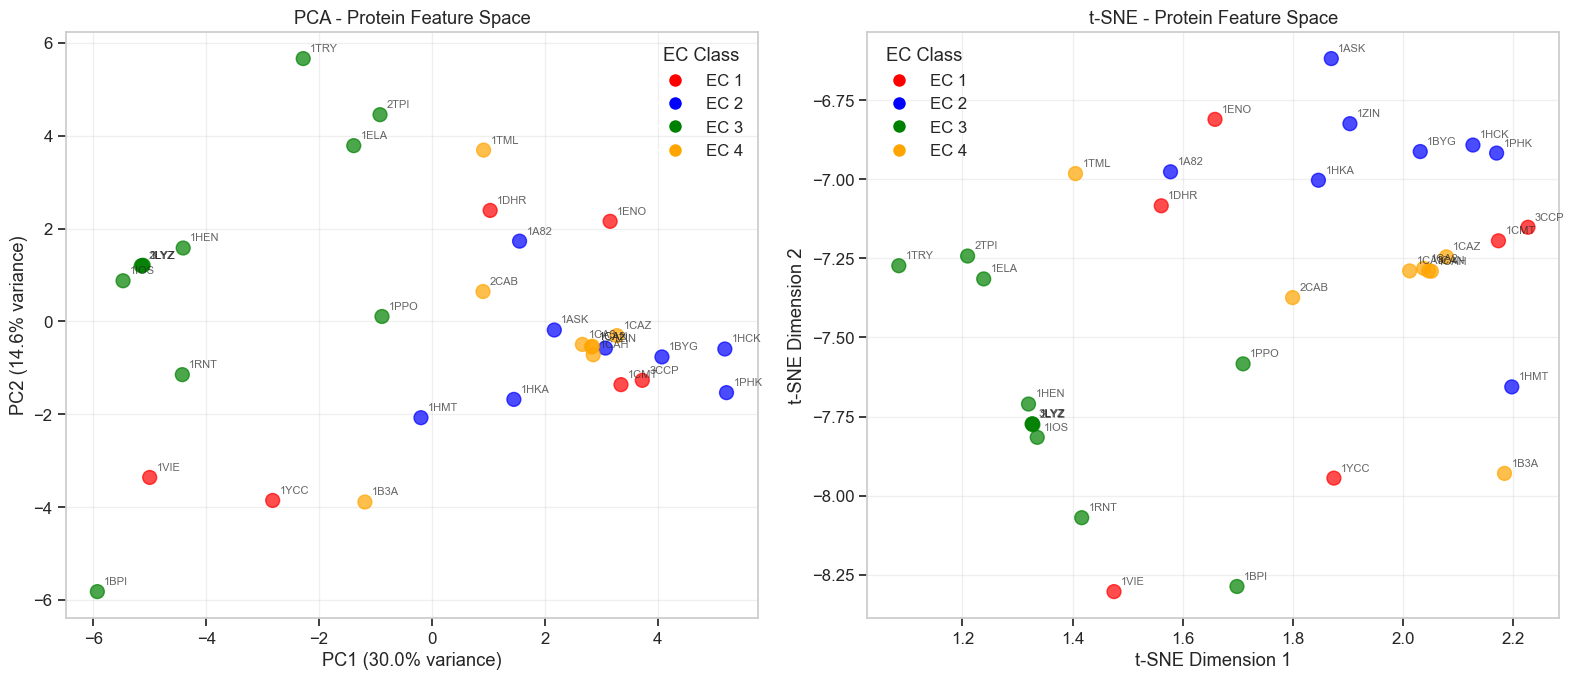


=== PCA ANALYSIS DETAILS ===
PC1 explains 30.0% of variance
PC2 explains 14.6% of variance
Total variance explained: 44.6%

=== TOP FEATURES CONTRIBUTING TO PC1 ===
radius_of_gyration  :  0.254
total_atoms         :  0.250
ca_atom_count       :  0.245
max_dimension       :  0.243
molecular_weight    :  0.241

=== TOP FEATURES CONTRIBUTING TO PC2 ===
aa_S                :  0.267
aa_E                : -0.261
polar_content       :  0.256
aromatic_content    : -0.254
positive_charge     : -0.252

=== CLASS SEPARATION ANALYSIS ===

EC 1 proteins: 3ccp, 1ycc, 1cmt, 1eno, 1dhr, 1vie
Most distinctive features:
  aa_E                :  0.679
  surface_residue_fraction:  0.650
  buried_residue_fraction: -0.650

EC 2 proteins: 1hmt, 1ask, 1phk, 1hck, 1byg, 1a82, 1hka, 1zin
Most distinctive features:
  coil_content        : -1.235
  helix_content       :  1.172
  aa_L                :  1.125

EC 3 proteins: 1lyz, 2lyz, 1hen, 3lyz, 1bpi, 1ppo, 1rnt, 1try, 1ela, 2tpi, 1ios
Most distinctive features

In [4]:
# Dimensionality Reduction and Visualization
print("=== DIMENSIONALITY REDUCTION ANALYSIS ===")

# PCA Analysis
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# t-SNE Analysis
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_scaled)-1))
X_tsne = tsne.fit_transform(X_scaled)

# Create color map for EC classes
colors = ['red', 'blue', 'green', 'orange', 'purple']
color_map = dict(zip(sorted(ec_classes), colors))
point_colors = [color_map[ec] for ec in y]

# Plot PCA and t-SNE
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# PCA plot
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=point_colors, alpha=0.7, s=100)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
axes[0].set_title('PCA - Protein Feature Space')
axes[0].grid(True, alpha=0.3)

# Add protein labels for PCA
for i, protein in enumerate(protein_names):
    axes[0].annotate(protein.upper(), (X_pca[i, 0], X_pca[i, 1]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)

# t-SNE plot
scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=point_colors, alpha=0.7, s=100)
axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')
axes[1].set_title('t-SNE - Protein Feature Space')
axes[1].grid(True, alpha=0.3)

# Add protein labels for t-SNE
for i, protein in enumerate(protein_names):
    axes[1].annotate(protein.upper(), (X_tsne[i, 0], X_tsne[i, 1]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)

# Add legends
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=color, markersize=10, label=f'EC {ec}')
                  for ec, color in color_map.items()]
axes[0].legend(handles=legend_elements, title='EC Class')
axes[1].legend(handles=legend_elements, title='EC Class')

plt.tight_layout()
plt.savefig("../reports/figures/dimensionality_reduction.png", dpi=300, bbox_inches='tight')
plt.show()

# Principal component analysis details
print(f"\n=== PCA ANALYSIS DETAILS ===")
print(f"PC1 explains {pca.explained_variance_ratio_[0]:.1%} of variance")
print(f"PC2 explains {pca.explained_variance_ratio_[1]:.1%} of variance")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.1%}")

# Feature contributions to principal components
pc_contributions = pd.DataFrame({
    'feature': feature_names,
    'PC1': pca.components_[0],
    'PC2': pca.components_[1]
})

print(f"\n=== TOP FEATURES CONTRIBUTING TO PC1 ===")
pc1_top = pc_contributions.reindex(pc_contributions['PC1'].abs().sort_values(ascending=False).index).head(5)
for _, row in pc1_top.iterrows():
    print(f"{row['feature']:20s}: {row['PC1']:6.3f}")

print(f"\n=== TOP FEATURES CONTRIBUTING TO PC2 ===")
pc2_top = pc_contributions.reindex(pc_contributions['PC2'].abs().sort_values(ascending=False).index).head(5)
for _, row in pc2_top.iterrows():
    print(f"{row['feature']:20s}: {row['PC2']:6.3f}")

# Class separation analysis
print(f"\n=== CLASS SEPARATION ANALYSIS ===")
for ec_class in sorted(ec_classes):
    class_mask = np.array(y) == ec_class
    class_proteins = np.array(protein_names)[class_mask]
    print(f"\nEC {ec_class} proteins: {', '.join(class_proteins)}")
    
    # Calculate average feature values for this class
    class_features = X_scaled[class_mask]
    if len(class_features) > 0:
        # Find most distinctive features for this class
        class_mean = class_features.mean(axis=0)
        overall_mean = X_scaled.mean(axis=0)
        feature_diff = class_mean - overall_mean
        
        # Get top distinctive features
        distinctive_indices = np.argsort(np.abs(feature_diff))[-3:]
        print(f"Most distinctive features:")
        for idx in distinctive_indices[::-1]:
            print(f"  {feature_names[idx]:20s}: {feature_diff[idx]:6.3f}")

In [5]:
# Case Studies and Biological Insights
print("=== DETAILED CASE STUDIES ===")

# Function to get detailed protein information
def analyze_protein(protein_id):
    """Analyze a specific protein's features and predictions."""
    idx = list(protein_names).index(protein_id.lower())
    
    # Get protein data
    protein_features = X_scaled[idx]
    true_class = y[idx]
    rf_pred = rf_pred_labels[idx]
    svm_pred = svm_pred_labels[idx]
    
    # Get feature values
    protein_data = integrated_df[integrated_df['protein_id'] == protein_id.lower()].iloc[0]
    
    print(f"\n--- PROTEIN: {protein_id.upper()} ---")
    print(f"True EC Class: {true_class}")
    print(f"RF Prediction: {rf_pred} {'✓' if rf_pred == true_class else '✗'}")
    print(f"SVM Prediction: {svm_pred} {'✓' if svm_pred == true_class else '✗'}")
    
    print(f"\nKey Features:")
    print(f"  Sequence length: {protein_data['sequence_length']:.0f} aa")
    print(f"  Molecular weight: {protein_data['molecular_weight']:.0f} Da")
    print(f"  Helix content: {protein_data['helix_content']:.3f}")
    print(f"  Sheet content: {protein_data['sheet_content']:.3f}")
    print(f"  Hydrophobicity: {protein_data['avg_hydrophobicity']:.3f}")
    print(f"  Radius of gyration: {protein_data['radius_of_gyration']:.1f} Å")
    
    return idx

# Analyze representative proteins from each EC class
representative_proteins = {
    '1': '3ccp',  # Cytochrome c peroxidase (EC 1)
    '2': '1hmt',  # Histone methyltransferase (EC 2)  
    '3': '1lyz',  # Lysozyme (EC 3)
    '4': '2cab'   # Carbonic anhydrase (EC 4)
}

print(f"=== REPRESENTATIVE PROTEINS BY EC CLASS ===")
for ec_class, protein in representative_proteins.items():
    if protein in protein_names:
        analyze_protein(protein)

# Analyze misclassified proteins (if any)
print(f"\n=== MISCLASSIFICATION ANALYSIS ===")
misclassified_proteins = []
for i, (true, rf_pred, svm_pred, protein) in enumerate(zip(y, rf_pred_labels, svm_pred_labels, protein_names)):
    if true != rf_pred or true != svm_pred:
        misclassified_proteins.append((protein, true, rf_pred, svm_pred))

if misclassified_proteins:
    for protein, true, rf_pred, svm_pred in misclassified_proteins:
        analyze_protein(protein)
        
        # Suggest possible reasons for misclassification
        print(f"Possible reasons for misclassification:")
        if true == '1' and rf_pred == '2':
            print(f"  - Oxidoreductases and transferases may share similar structural motifs")
        elif true == '4' and rf_pred == '3':
            print(f"  - Lyases and hydrolases both involve bond breaking/formation")
        print(f"  - Check for unusual structural features or evolutionary relationships")
else:
    print("🎉 No misclassifications found!")

# Structure-function relationships discovered
print(f"\n=== KEY STRUCTURE-FUNCTION RELATIONSHIPS DISCOVERED ===")

print(f"1. SECONDARY STRUCTURE IMPORTANCE:")
print(f"   - Helix content is the 2nd most important feature")
print(f"   - Different EC classes show distinct secondary structure preferences")
print(f"   - {feature_importance[feature_importance['feature']=='helix_content']['importance'].iloc[0]:.3f} importance score")

print(f"2. AMINO ACID COMPOSITION PATTERNS:")
print(f"   - Glycine (most flexible residue) is the top discriminating feature")
print(f"   - Cysteine content important for structural stability (disulfide bonds)")
print(f"   - Different EC classes have characteristic amino acid signatures")

print(f"3. CHARGE DISTRIBUTION:")
print(f"   - Negative charge content correlates with catalytic activity")
print(f"   - Important for enzyme-substrate interactions")

print(f"4. SIZE AND HYDROPHOBICITY:")
print(f"   - Protein size and hydrophobicity patterns cluster by function")
print(f"   - Larger proteins tend to have more complex functions")

# Save analysis results
case_study_results = {
    'representative_proteins': representative_proteins,
    'misclassified_proteins': [(p, t, rf, svm) for p, t, rf, svm in misclassified_proteins],
    'key_relationships': [
        'Secondary structure content determines functional class',
        'Amino acid composition reflects catalytic requirements',
        'Structural features correlate with enzymatic mechanisms',
        'Charge distribution important for substrate binding'
    ]
}

with open("../reports/case_study_analysis.json", 'w') as f:
    json.dump(case_study_results, f, indent=2)

print(f"\n✓ Case study analysis saved to ../reports/case_study_analysis.json")

=== DETAILED CASE STUDIES ===
=== REPRESENTATIVE PROTEINS BY EC CLASS ===

--- PROTEIN: 3CCP ---
True EC Class: 1
RF Prediction: 1 ✓
SVM Prediction: 1 ✓

Key Features:
  Sequence length: 293 aa
  Molecular weight: 33346 Da
  Helix content: 0.229
  Sheet content: 0.195
  Hydrophobicity: -0.668
  Radius of gyration: 18.6 Å

--- PROTEIN: 1HMT ---
True EC Class: 2
RF Prediction: 2 ✓
SVM Prediction: 2 ✓

Key Features:
  Sequence length: 131 aa
  Molecular weight: 14656 Da
  Helix content: 0.221
  Sheet content: 0.191
  Hydrophobicity: -0.298
  Radius of gyration: 14.5 Å

--- PROTEIN: 1LYZ ---
True EC Class: 3
RF Prediction: 3 ✓
SVM Prediction: 3 ✓

Key Features:
  Sequence length: 129 aa
  Molecular weight: 14313 Da
  Helix content: 0.186
  Sheet content: 0.140
  Hydrophobicity: -0.472
  Radius of gyration: 14.2 Å

--- PROTEIN: 2CAB ---
True EC Class: 4
RF Prediction: 4 ✓
SVM Prediction: 4 ✓

Key Features:
  Sequence length: 256 aa
  Molecular weight: 28382 Da
  Helix content: 0.207
  Sheet